1. Run dbt project to create snowflake table with required data
2. Import data from snowflake to s3

1. dbt scheduler creates training data in snowflake
2. This gets pushed to s3 from WH actions


### Defining constants

In [1]:
# AWS DATA BUCKET where both input data is stored, and output data should be stored.
S3_BUCKET = 'dileep-dev'

# INPUT DATA LOCATION. Folder within aws bucket where input data is stored as json files (extracted from Rudderstack Reverse ETL)
S3_INPUT_FOLDER_LOCATION = 'rudder_wh_actions_usecases_attribution_raw_data'
# INPUT LABEL LOCATION. Folder within aws bucket where input label data is stored as json files (extracted from Rudderstack Reverse ETL)
S3_LABEL_DATA_FOLDER_LOCATION = 'rudder_wh_actions_usecases_attribution_label_data'

# Output location. Folder within aws bucket where output data 
S3_OUTPUT_FOLDER_LOCATION='rudder_wh_actions_usecases_attribution_lead_scoring'

# MODEL CONFIGURATION.

# The input data may sometimes contain a touch that is not required and you choose to drop them. 
# Such touches should be added to this list. 
# If all touches should be considered, we can pass an empty list (ex: IGNORE_TOUCHES=[])
IGNORE_TOUCHES = ["request-demo", 'product', 'marketing_newsletter_sent', 'marketing_campaign_sent', 'sf_outbound_email', 'sf_inbound_email', 'marketing_newsletter_clicked', 'marketing_campaign_clicked']


# We may want to combine a few touches into one group. Ex: all video ads from different sources may be combined into one.
# In such case, we make below flag True (else, False) and create a touchpoint_mapping dictionary (see below) to group related touch points together
GROUP_TOUCHES = True

# This is required only if GROUP_TOUCHES = True. In below mapping, each key corresponds to a touch we want to group. 
# Ex, sources, directory, home etc are all converted to 'webapp' and video-library, guides, case-studies are converted to 'docs'
# If a touch is not found in the key, no modification is applied on that and it stays as is.
touchpoint_mapping = {"":"webapp",
                      "others": None,
                      "sources": "webapp",
                      "directory": "webapp",
                      "home": "webapp",
                      "signup": None,
                      "destinations": "webapp",
                      "integration": "product",
                      "login": None,
                      "syncs": "webapp",
                      "profile": None,
                      "transformations": "product",
                      "team": "webapp",
                      "rudderstack-vs-segment": None,
                      "video-library": "docs",
                      "guides": "docs",
                      "rudderstack-vs-snowplow": None,
                      'case-studies': 'docs', 
                      'join-rudderstack-slack': 'join_slack', 
                      'join-rudderstack-slack-community': 'join_slack'}

#touchpoint_mapping = None # If no mapping is required.

# Ignores any data before this date. If not required, we can give it as None
MIN_DATE = '2021-06-01'
#MIN_DATE = None # If not required

# Dedup logic. IF same event repeats consecutively within this interval (in seconds), they are considered the same and first occurence timestamp is counted. 
# If we don't want a dedup logic, we can make this value as 0.
MIN_EVENT_INTERVAL_IN_SEC = 300




In [2]:

# LGOISTIC REGRESSION PARAMETERS. THESE ARE USUALLY NOT CHANGED
l1_penalty = .1
metrics_list = ["roc_auc", "f1", "precision", "recall", "pr_auc"]


### Loading data from s3

In [3]:
import json
import boto3
import os
import sys
import gzip
from typing import List, Optional
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import average_precision_score, ConfusionMatrixDisplay
from sklearn.metrics import auc, plot_precision_recall_curve
import pickle

import logging
import yaml
from dataclasses import dataclass
pd.set_option('display.max_columns', None)
from tqdm import tqdm

tqdm.pandas()

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

output_file_handler = logging.FileHandler("lead_scoring_training.log")
stdout_handler = logging.StreamHandler(sys.stdout)

logger.addHandler(output_file_handler)
logger.addHandler(stdout_handler)
logging.getLogger('matplotlib.font_manager').disabled = True


In [5]:

# Helper functions to load input data
def load_json(json_str: str,
              key: Optional[str]=None):
    if key:
        return json.loads(json_str)[key]
    else:
        return json.loads(json_str)

def load_s3_compressed_dictionary_object(s3_file_object, key: Optional[str]=None):
    with gzip.GzipFile(fileobj=s3_file_object.get()['Body']) as gzipfile:
        content = gzipfile.read().decode('utf-8').split('\n')
    
    return [load_json(line, key) for line in content if line]

def load_json_data_from_s3(s3_instance, s3_bucket_name: str, files_prefix: str, json_dict_key: Optional[str]=None) -> pd.DataFrame:
    bucket = s3_instance.Bucket(s3_bucket_name)
    all_rows = []
    for file_obj in tqdm(bucket.objects.filter(Prefix=files_prefix)):
        all_rows.append(load_s3_compressed_dictionary_object(file_obj, json_dict_key))
    
    df = pd.DataFrame.from_records([row for rows in all_rows for row in rows])
    df.columns = [col.lower() for col in list(df)]
    return df


In [6]:
%%time
# Loading data from Reverse ETL output into Python
s3 = boto3.resource("s3")

raw_data = load_json_data_from_s3(s3, S3_BUCKET, S3_INPUT_FOLDER_LOCATION, json_dict_key='traits')
raw_data["timestamp"] = pd.to_datetime(raw_data["timestamp"]).dt.tz_localize(None)

label_data = load_json_data_from_s3(s3, S3_BUCKET, S3_LABEL_DATA_FOLDER_LOCATION, json_dict_key='traits')
label_data['call_conversion_time'] = pd.to_datetime(label_data['call_conversion_time']).dt.tz_localize(None)

51it [00:18,  2.76it/s]
1it [00:00, 14.46it/s]

CPU times: user 17 s, sys: 1.16 s, total: 18.2 s
Wall time: 21 s


In [7]:
domain_conversion_dates = label_data.set_index("domain").to_dict()['call_conversion_time']
raw_data = raw_data.drop(columns=['row_id', 'call_conversion_time']).drop_duplicates()

## Data prep after downloading from DBT output

In [8]:
# Transformations on the raw data. We apply the constraints defined in the constants cell above.

def dedup_by_ts_delta(df: pd.DataFrame, primary_key: str, timestamp: str, event_type: str, max_lag: int) -> pd.DataFrame:
    """
    ### Parameters
    1. df : pd.DataFrame
        - User touches dataframe. 
    2. primary_key : str
        - column name of the column that contains user_id. 
    3. timestamp: str
        - column name of the column that contains event timestamp
    4. event_type: str
        - column name of the column that contains event/touch data
    5. max_lag: int
        - max time (in sec) between consecutive events to be considered as duplicates. 

    ### Returns
    - DataFrame after doing following steps
    Based on primary key and event_type, it checks if two consecutive events occur within the max_lag time window. If so, they are considered same event and the latter event is dropped. 
    """
    if max_lag <= 0:
        return df
    df = df.sort_values(by=[primary_key, timestamp], ascending=True).reset_index(drop=True)
    original_columns = df.columns
    df["prev_user"] = df[primary_key].shift()
    df["prev_event"] = df[event_type].shift()
    df["prev_ts"] = df[timestamp].shift()

    def is_duplicate(row):
        if pd.isnull(row["prev_user"]) or pd.isnull(row["prev_event"]) or pd.isnull(row["prev_ts"]):
            return False
        elif row[primary_key] == row["prev_user"] and row[event_type] == row["prev_event"] and (
                row[timestamp] - row["prev_ts"]).total_seconds() <= max_lag:
            return True
        else:
            return False

    df["is_duplicate"] = df.progress_apply(is_duplicate, axis=1)
    return df.query("is_duplicate==False")[original_columns].reset_index(drop=True)

def process_raw_data(raw_data_df: pd.DataFrame,
                     ignore_touches: List[str],
                     min_date: Optional[str],
                     dedup_min_time: int,
                     reduce_touches: bool = True) -> pd.DataFrame:
    """
    ### Parameters
    1. raw_data_df : Raw data 
    2. ignore_touches: Ignores the touches present in this list. 
    3. min_date: Ignores events before this date
    4. dedup_min_time: Time (in sec) between two events of same type. Events that repeat within this interval are combined as one (earlier timestamp is considered)
    5. reduce_touches : Whether to combine touchpoints based on their logical groupings

    ### Returns
    - DataFrame after doing following steps
    1. Groups tracks pages if reduce_touches flag is True
    2. Deduplicates based on 5 min interval 
    3. Ignores touches based on ignore_touches list
    4. Ðrops events before the min_date timestamp.
    """
    if reduce_touches:
        raw_data_df["touch"] = raw_data_df["touch"].apply(lambda touch: touchpoint_mapping.get(touch, touch))
    
    dedup_data_df = (dedup_by_ts_delta(raw_data_df
                                       .query("~touch.isnull()",
                                              engine='python')
                                       .drop_duplicates(),
                                       "domain",
                                       "timestamp", 
                                       "touch", 
                                       dedup_min_time)
                     .filter(['domain', 'touch', 'timestamp', 'is_mql', 'touch_category'])
                    )
    if min_date:
        return dedup_data_df.query(f'touch not in @ignore_touches and timestamp >= "{min_date}"', engine='python')
    else:
        return dedup_data_df.query(f'touch not in @ignore_touches', engine='python')

In [9]:
%%time
touch_data_filtered = process_raw_data(raw_data, IGNORE_TOUCHES, MIN_DATE, MIN_EVENT_INTERVAL_IN_SEC, GROUP_TOUCHES)
del raw_data

NumExpr defaulting to 2 threads.


100%|██████████| 717733/717733 [00:51<00:00, 13917.69it/s]


CPU times: user 54.5 s, sys: 232 ms, total: 54.8 s
Wall time: 54.7 s


In [10]:
# Combining the label data to events data
touch_data_filtered['call_conversion_time'] = touch_data_filtered['domain'].apply(lambda domain: domain_conversion_dates.get(domain,None))

In [11]:
touch_data_filtered.head()

,domain,touch,timestamp,is_mql,touch_category,call_conversion_time
0,.company.com,join_slack,2021-12-15 10:44:50.051,NaN,tracks,NaT
1,.company.com,form_submit,2021-12-15 10:46:43.004,NaN,signup,NaT
2,.company.com,join_slack,2021-12-15 10:49:25.341,NaN,tracks,NaT
31,100xbit.com,user_signed_up,2021-08-09 15:55:39.069,0.0,signup,NaT
36,100xbit.com,marketing_newsletter_opened,2021-09-07 23:07:40.000,0.0,marketing,NaT


In [12]:
touch_data_filtered['touch'].value_counts()

webapp                         67150
marketing_newsletter_opened    41444
docs                           17274
marketing_campaign_opened       9599
pricing                         4713
blog                            3883
user_signed_up                  2478
form_submit                     1141
join_slack                       735
careers                          109
Name: touch, dtype: int64

In [13]:
len(touch_data_filtered)

148526

In [14]:
touch_data_filtered.query("~call_conversion_time.isnull()", engine='python').head()

,domain,touch,timestamp,is_mql,touch_category,call_conversion_time
1399,30lines.com,pricing,2021-12-07 10:12:01.727,1.0,tracks,2022-01-07 08:00:00
1400,30lines.com,docs,2021-12-07 10:14:36.445,1.0,tracks,2022-01-07 08:00:00
1401,30lines.com,webapp,2021-12-07 22:11:05.096,1.0,tracks,2022-01-07 08:00:00
1402,30lines.com,blog,2021-12-07 22:11:52.103,1.0,tracks,2022-01-07 08:00:00
1404,30lines.com,docs,2021-12-31 21:35:04.665,1.0,tracks,2022-01-07 08:00:00


### Loading Datasets

In [15]:
def get_days_diff(row: dict, default_dt, timestamp_col: str, conversion_timestamp_col: str) -> int:
    if pd.isnull(row[conversion_timestamp_col]):
        return (default_dt - row[timestamp_col]).days
    else:
        return (row[conversion_timestamp_col] - row[timestamp_col]).days

def keep_record(row):
    if row['user_signed_up'] + row['form_submit'] == 0:
        return False
    elif sum([value for key, value in row.items() if key not in ['label', 'days_since_first_seen']]) > 0:
        return True
    else:
        return False

def get_feature_data(touch_data_df: pd.DataFrame):
    domain_data = touch_data_df.groupby(['domain', 'is_mql']).agg({"timestamp": "min", 
                                                                   'call_conversion_time': "max"}).reset_index().set_index("domain")
    max_ts = domain_data['timestamp'].max()
    domain_data["days_since_first_seen"] = domain_data.apply(lambda row: get_days_diff(row, max_ts, 'timestamp', 'call_conversion_time'), axis=1)
    domain_data['label'] = domain_data['call_conversion_time'].apply(lambda ct: 0 if pd.isna(ct) else 1)
    touch_counts_df = pd.crosstab(touch_data_df['domain'], touch_data_df['touch'])
    features_df = touch_counts_df.merge(domain_data[["is_mql", "days_since_first_seen", "label"]], left_index=True, right_index=True)
    #return features_df
    features_df['keep_row'] = features_df.apply(keep_record, axis=1)
    return features_df.query("keep_row").drop(columns=['keep_row'])

In [16]:
features_data = get_feature_data(touch_data_filtered)

In [17]:
features_data.head()

,blog,careers,docs,form_submit,join_slack,marketing_campaign_opened,marketing_newsletter_opened,pricing,user_signed_up,webapp,is_mql,days_since_first_seen,label
domain,,,,,,,,,,,,,
100xbit.com,0,0,0,0,0,0,1,0,1,0,0.0,177,0
101labs.org,0,0,0,0,0,0,0,0,1,0,0.0,239,0
10minuteschool.com,1,0,4,1,0,2,37,3,1,42,1.0,122,0
11td.com,0,0,0,0,0,0,0,1,1,3,0.0,220,0
123980.com,7,0,16,1,0,0,0,13,0,26,0.0,104,0


### Checking data distribution

In [18]:
features_data['label'].value_counts()

0    2964
1     235
Name: label, dtype: int64

In [19]:
features_data['label'].value_counts(normalize=True)

0    0.92654
1    0.07346
Name: label, dtype: float64

In [20]:
features_data.head()

,blog,careers,docs,form_submit,join_slack,marketing_campaign_opened,marketing_newsletter_opened,pricing,user_signed_up,webapp,is_mql,days_since_first_seen,label
domain,,,,,,,,,,,,,
100xbit.com,0,0,0,0,0,0,1,0,1,0,0.0,177,0
101labs.org,0,0,0,0,0,0,0,0,1,0,0.0,239,0
10minuteschool.com,1,0,4,1,0,2,37,3,1,42,1.0,122,0
11td.com,0,0,0,0,0,0,0,1,1,3,0.0,220,0
123980.com,7,0,16,1,0,0,0,13,0,26,0.0,104,0


In [21]:
print("No:of distinct events for converting users")
features_data.query("label==1").drop(columns=["days_since_first_seen", "label"]).astype(bool).sum(axis=1).describe()

No:of distinct events for converting users


count    235.000000
mean       5.123404
std        2.125769
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       10.000000
dtype: float64

In [22]:
print("No:of distinct events for non-converting users")
features_data.query("label==0").drop(columns=["days_since_first_seen", "label"]).astype(bool).sum(axis=1).describe()

No:of distinct events for non-converting users


count    2964.000000
mean        4.304656
std         1.997796
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        11.000000
dtype: float64

In [23]:
print("No:of total events for converting users")
features_data.query("label==1").drop(columns=["days_since_first_seen", "label"]).sum(axis=1).describe()

No:of total events for converting users


count    235.000000
mean      29.174468
std       46.064979
min        1.000000
25%        6.000000
50%       12.000000
75%       30.500000
max      356.000000
dtype: float64

In [24]:
print("No:of total events for non-converting users")
features_data.query("label==0").drop(columns=["days_since_first_seen", "label"]).sum(axis=1).describe()

No:of total events for non-converting users


count    2964.000000
mean       31.313765
std        72.394432
min         1.000000
25%         5.000000
50%        11.000000
75%        28.000000
max      1512.000000
dtype: float64

In [25]:
print("Days since first seen to conversion (or non-conversion)")
median = lambda x: np.percentile(x,50)
features_data.groupby("label").agg({"days_since_first_seen": ["min","max","mean", median]})

Days since first seen to conversion (or non-conversion)


days_since_first_seen                            
                        min  max        mean <lambda_0>
label                                                  
0                         0  247  117.653171        106
1                         0  220   26.404255         12

## Modeling

In [26]:
def get_classification_metrics(y_true, y_pred_proba, th=0.5, as_dict=True):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, np.where(y_pred_proba>th,1,0))
    precision = precision[1]
    recall = recall[1]
    f1 = f1[1]
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    metrics = {"precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, 'pr_auc': pr_auc}
    if as_dict:
        return metrics
    else:
        return pd.DataFrame.from_dict(metrics, orient='index')

def get_best_th(y_true, y_pred_proba):
    """
    Returns the threshold that maximizes f1 score based on y_true and y_pred_proba
    Also returns the metrics at the threshold
    y_true: Array of 1s and 0s. True labels
    y_pred_proba: Array of predicted probabilities
    """
    best_f1 = 0.0
    best_th = 0.0

    for th in np.arange(0,1,0.01):
        f1 = f1_score(y_true, np.where(y_pred_proba>th,1,0))
        if f1 >= best_f1:
            best_th = th
            best_f1 = f1
            
    best_metrics = get_classification_metrics(y_true, y_pred_proba, best_th)
    return best_metrics, best_th

def positives_at_decile(y_true, y_pred_proba, return_df=True):
    decile_counts = {}
    for th_low in np.arange(0, 1, 0.1):
        decile_counts[th_low] = (y_true[(th_low<=y_pred_proba)&(y_pred_proba<(th_low+0.1))].value_counts().to_dict())
    if return_df:
        df = pd.DataFrame.from_dict(decile_counts, orient='index').fillna(0).astype(int).sort_index()
        df["1_z"] = df.apply(lambda row: np.round(row[1]/(row[0] + row[1]),4), axis=1)
        return df
    else:
        return decile_counts

In [27]:
pd.crosstab(features_data["is_mql"], features_data["label"])

label,0,1
is_mql,,
0.0,2229,98
1.0,735,137


 ~40% of conversions are non-mql

In [28]:
logger.info("Splitting the data into train-test data at ratio of 33% for test.")
X_train, X_test, y_train, y_test = train_test_split(features_data.drop(columns=["label"]), 
                                                    features_data["label"],
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=features_data[["label", "is_mql"]])


Splitting the data into train-test data at ratio of 33% for test.


In [29]:
X_train["is_mql"].value_counts()

0.0    1559
1.0     584
Name: is_mql, dtype: int64

In [30]:
X_test["is_mql"].value_counts()

0.0    768
1.0    288
Name: is_mql, dtype: int64

### Logistic Regression

In [31]:
from IPython.display import display

In [32]:
def run_logistic_regression(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, l1_penalty: float):
    logging.info(f"Building logistic regression with C value {l1_penalty}")
    logistic = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=l1_penalty)
    logistic.fit(X_train, y_train)
    y_pred = logistic.predict_proba(X_test)

    best_metrics, best_th = get_best_th(y_test, y_pred[:, 1] )
    logger.info(f"Threshold that gives highest f1-score: {best_th:.2f}. Corresponding metrics:")
    logger.info([f"{metric}: {best_metrics[metric]:.2f}" for metric in metrics_list])
    print("Confusion Matrix:")
    dsp = ConfusionMatrixDisplay(confusion_matrix(y_test, np.where(y_pred[:,1]>=best_th,1,0)), display_labels=logistic.classes_)
    dsp.plot()
    plt.show()
    print("\nDecile counts:")
    decile_counts_test_df = positives_at_decile(y_test, y_pred[:,1])
    display(decile_counts_test_df)
    logistic_coefs = pd.DataFrame.from_dict(dict(zip(list(X_train),np.round(logistic.coef_, 3)[0])), orient="index").reset_index()
    logistic_coefs.columns = ["event", "coef"]
    logger.info(f"\nConstant: {logistic.intercept_[0]:.4f}")
    logging.info(logistic_coefs.sort_values("coef", ascending=False))
    response = {"model": logistic, "metrics": best_metrics, "threshold": best_th}
    return response

Building logistic regression with C value 0.1
Threshold that gives highest f1-score: 0.34. Corresponding metrics:
['roc_auc: 0.94', 'f1: 0.65', 'precision: 0.62', 'recall: 0.69', 'pr_auc: 0.59']
Confusion Matrix:


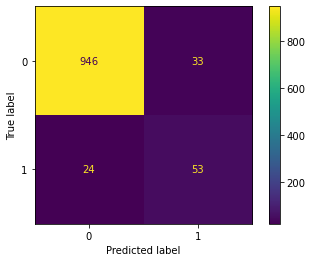


Decile counts:


,0,1,1_z
0.0,845,7,0.0082
0.1,62,7,0.1014
0.2,29,8,0.2162
0.3,18,8,0.3077
0.4,5,9,0.6429
0.5,7,13,0.6500
0.6,4,8,0.6667
0.7,3,9,0.7500
0.8,5,5,0.5000
0.9,1,3,0.7500



Constant: -0.5268
                          event   coef
10                       is_mql  0.888
3                   form_submit  0.474
7                       pricing  0.358
6   marketing_newsletter_opened  0.052
9                        webapp  0.013
0                          blog  0.000
1                       careers  0.000
4                    join_slack  0.000
5     marketing_campaign_opened  0.000
11        days_since_first_seen -0.047
2                          docs -0.101
8                user_signed_up -0.708


In [33]:
all_users_response_with_mql_flag = run_logistic_regression(X_train, X_test, y_train, y_test, l1_penalty)

In [34]:
features_data.groupby('label')['docs'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,2964.0,4.634615,16.084880,0.0,0.0,0.0,2.0,306.0
1,235.0,2.893617,7.713996,0.0,0.0,0.0,2.0,56.0


In [35]:
features_data.groupby('label')['marketing_newsletter_opened'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,2964.0,5.835020,11.977230,0.0,0.0,1.0,7.0,269.0
1,235.0,2.340426,5.413171,0.0,0.0,0.0,2.0,37.0


In [36]:
features_data.groupby('label')['marketing_campaign_opened'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,2964.0,1.923752,4.595805,0.0,0.0,0.0,2.0,50.0
1,235.0,1.097872,2.117034,0.0,0.0,0.0,1.0,11.0


In [37]:
features_data.query("docs>15").sample(5)

,blog,careers,docs,form_submit,join_slack,marketing_campaign_opened,marketing_newsletter_opened,pricing,user_signed_up,webapp,is_mql,days_since_first_seen,label
domain,,,,,,,,,,,,,
getmega.com,1,0,27,1,1,0,0,3,1,79,0.0,26,0
gasworksmedia.com,3,0,35,0,2,1,1,3,1,53,0.0,162,0
segment.com,8,0,17,1,0,1,43,0,0,9,0.0,237,0
ingrow.co,2,0,26,0,0,2,0,1,1,35,0.0,129,0
forgerock.com,1,0,16,1,1,2,9,3,1,17,1.0,64,0


Interesting that docs and marketing_newsletter have negative coefficients. Docs seem to be driven by outliers. 75th percentile for non-converted users has docs count = 0 but max is 93 compared to only 18 for converted. Probably high docs count before a call indicate competitors, research, or open-source propensity.

Newsletter high count too is bad. This is throughout the curve, with all percentiles having high newsletter counts. This may be a confounding variable based on the fact that a user didn't convert for a long time which resulted in a lot of newsletter mails. 

In [38]:
@dataclass
class PrecisionRecallMetrics:
    precision: List[float]
    recall: List[float]
    threshold: List[float]



In [39]:
all_users_pr_metrics = (precision_recall_curve(y_test, 
                                               all_users_response_with_mql_flag["model"].predict_proba(X_test)[:,1]))

all_users_pr_metrics = PrecisionRecallMetrics(*all_users_pr_metrics)

non_mql_users_pr_metrics = (precision_recall_curve(y_test[X_test['is_mql']==0], 
                                                   all_users_response_with_mql_flag["model"].predict_proba(X_test.query("is_mql==0"))[:,1]))

non_mql_users_pr_metrics = PrecisionRecallMetrics(*non_mql_users_pr_metrics)

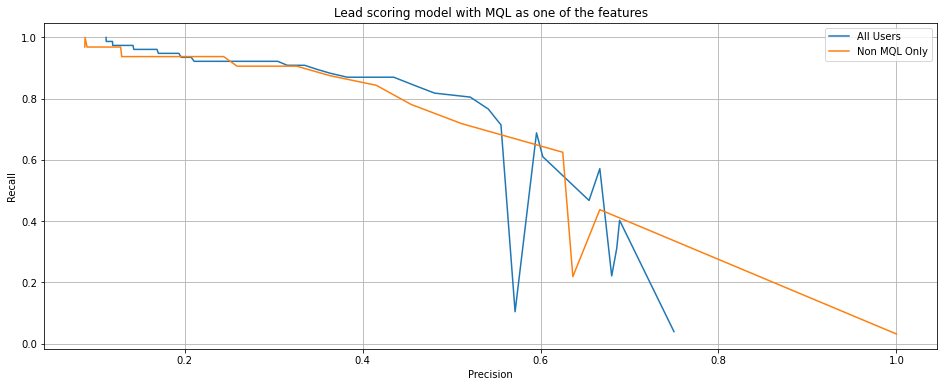

In [40]:
plt.figure(figsize=(16,6))
sns.lineplot(x=all_users_pr_metrics.precision[::10], y=all_users_pr_metrics.recall[::10])
sns.lineplot(x=non_mql_users_pr_metrics.precision[::10], y=non_mql_users_pr_metrics.recall[::10])
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)
plt.legend(["All Users", "Non MQL Only"])
plt.title("Lead scoring model with MQL as one of the features");

# Timebounding

In [41]:
max_time = touch_data_filtered['timestamp'].max()

In [42]:
delta_days = lambda row: (max_time - row['timestamp']).days if pd.isna(row['call_conversion_time']) else (row['call_conversion_time'] - row['timestamp']).days
touch_data_filtered['delta_days'] = touch_data_filtered.apply(delta_days,axis=1)

In [43]:
touch_data_filtered.head()

,domain,touch,timestamp,is_mql,touch_category,call_conversion_time,delta_days
0,.company.com,join_slack,2021-12-15 10:44:50.051,NaN,tracks,NaT,49
1,.company.com,form_submit,2021-12-15 10:46:43.004,NaN,signup,NaT,49
2,.company.com,join_slack,2021-12-15 10:49:25.341,NaN,tracks,NaT,49
31,100xbit.com,user_signed_up,2021-08-09 15:55:39.069,0.0,signup,NaT,177
36,100xbit.com,marketing_newsletter_opened,2021-09-07 23:07:40.000,0.0,marketing,NaT,148


In [44]:
logger.info("Converted domains: ")
logger.info(f"\tTotal: {len(touch_data_filtered.query('~call_conversion_time.isnull()', engine='python')['domain'].unique())}")
logger.info(f"\tIgnoring events in 3 days of conversion: {len(touch_data_filtered.query('~call_conversion_time.isnull() and delta_days >= 3', engine='python')['domain'].unique())}")
logger.info(f"\tConsidering only 3-90 days events: {len(touch_data_filtered.query('~call_conversion_time.isnull() and delta_days >= 3 and delta_days <= 90', engine='python')['domain'].unique())}")
logger.info("\nNon-converted domains:")
logger.info(f"\tTotal: {len(touch_data_filtered.query('call_conversion_time.isnull()', engine='python')['domain'].unique())}")
logger.info(f"\tIgnoring events in 3 days of conversion: {len(touch_data_filtered.query('call_conversion_time.isnull() and delta_days >= 3', engine='python')['domain'].unique())}")
logger.info(f"\tConsidering only 3-90 days events: {len(touch_data_filtered.query('call_conversion_time.isnull() and delta_days >= 3 and delta_days <= 90', engine='python')['domain'].unique())}")

Converted domains: 
	Total: 273
	Ignoring events in 3 days of conversion: 230
	Considering only 3-90 days events: 229

Non-converted domains:
	Total: 5656
	Ignoring events in 3 days of conversion: 5599
	Considering only 3-90 days events: 4556


In [45]:
## Building model only with events done >= 3 days of conversion, and <= 90 days - to prevent data leakage
data_features_timed = get_feature_data(touch_data_filtered.query("delta_days>=3 and delta_days<=90"))
logging.info(f"Loaded data of {len(data_features_timed)} domains after keeping only events between 3 and 90 days of conversion/last-seen date")

Loaded data of 1538 domains after keeping only events between 3 and 90 days of conversion/last-seen date


In [46]:
len(data_features_timed)

1538

In [47]:
data_features_timed['label'].value_counts(normalize=True)

0    0.892718
1    0.107282
Name: label, dtype: float64

In [48]:
pd.crosstab(data_features_timed["is_mql"], data_features_timed["label"])

label,0,1
is_mql,,
0.0,1057,65
1.0,316,100


Splitting the data into train-test data at ratio of 33% for test.
Building logistic regression with C value 0.1
Threshold that gives highest f1-score: 0.30. Corresponding metrics:
['roc_auc: 0.92', 'f1: 0.66', 'precision: 0.67', 'recall: 0.65', 'pr_auc: 0.58']
Confusion Matrix:


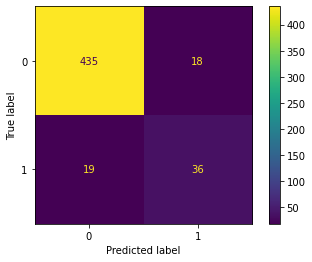


Decile counts:


,0,1,1_z
0.0,348,4,0.0114
0.1,56,8,0.1250
0.2,31,7,0.1842
0.3,8,8,0.5000
0.4,2,8,0.8000
0.5,2,12,0.8571
0.6,1,5,0.8333
0.7,0,1,1.0000
0.9,5,2,0.2857



Constant: -0.4403
                          event   coef
10                       is_mql  0.831
0                          blog  0.163
7                       pricing  0.144
6   marketing_newsletter_opened  0.110
9                        webapp  0.064
1                       careers  0.000
3                   form_submit  0.000
4                    join_slack  0.000
5     marketing_campaign_opened  0.000
11        days_since_first_seen -0.058
2                          docs -0.169
8                user_signed_up -0.600


In [49]:
logging.info("Splitting the data into train-test data at ratio of 33% for test.")
X_train, X_test, y_train, y_test = train_test_split(data_features_timed.drop(columns=["label"]), 
                                                    data_features_timed["label"],
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=data_features_timed[["label", "is_mql"]])
all_users_response_with_mql_flag_timed = run_logistic_regression(X_train, X_test, y_train, y_test, l1_penalty)

In [50]:
all_users_pr_metrics = (precision_recall_curve(y_test, 
                                               all_users_response_with_mql_flag_timed["model"].predict_proba(X_test)[:,1]))

all_users_pr_metrics = PrecisionRecallMetrics(*all_users_pr_metrics)

non_mql_users_pr_metrics = (precision_recall_curve(y_test[X_test['is_mql']==0], 
                                                   all_users_response_with_mql_flag_timed["model"].predict_proba(X_test.query("is_mql==0"))[:,1]))

non_mql_users_pr_metrics = PrecisionRecallMetrics(*non_mql_users_pr_metrics)

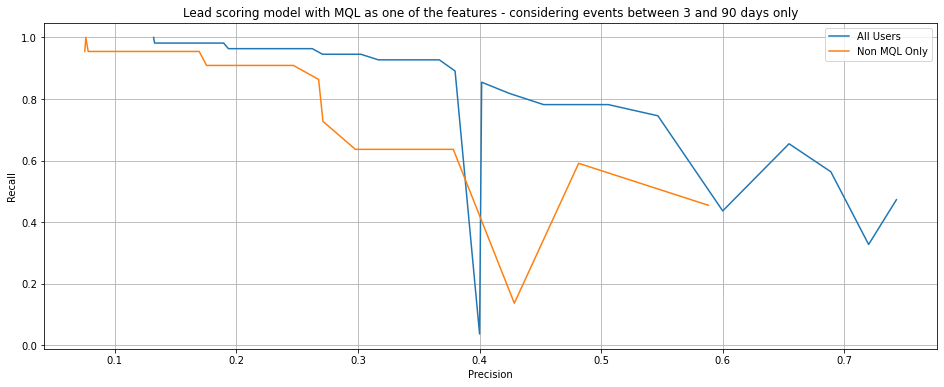

In [51]:
plt.figure(figsize=(16,6))
sns.lineplot(x=all_users_pr_metrics.precision[::10], y=all_users_pr_metrics.recall[::10])
sns.lineplot(x=non_mql_users_pr_metrics.precision[::10], y=non_mql_users_pr_metrics.recall[::10])
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)
plt.legend(["All Users", "Non MQL Only"])
plt.title("Lead scoring model with MQL as one of the features - considering events between 3 and 90 days only");

In [52]:
data_features_timed['score'] = all_users_response_with_mql_flag_timed['model'].predict_proba(data_features_timed.drop(columns=['label']))[:,1]

In [53]:
data_features_timed.head()

,blog,careers,docs,form_submit,join_slack,marketing_campaign_opened,marketing_newsletter_opened,pricing,user_signed_up,webapp,is_mql,days_since_first_seen,label,score
domain,,,,,,,,,,,,,,
123980.com,6,0,15,1,0,0,0,13,0,22,0.0,82,0,0.029043
13dkmail.cf,0,0,0,0,0,0,0,0,1,0,0.0,45,0,0.024890
1770.us,0,0,0,0,0,0,0,0,1,2,0.0,69,0,0.007092
1mo.fun,0,0,5,0,0,0,0,1,1,15,0.0,38,0,0.047387
1stopcbdbusiness.com,0,0,0,1,0,0,7,0,0,2,0.0,63,0,0.038468


In [54]:
time_suffix = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%dT%H:%M:%S')
output_location = f"s3://{S3_BUCKET}/{S3_OUTPUT_FOLDER_LOCATION}/{time_suffix}"
data_features_timed.to_parquet(f"{output_location}/scores.parquet")

ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
ascii should target any language(s) of ['Latin Based']
We detected language [('English', 1.0), ('Indonesian', 1.0), ('Simple English', 1.0)] using ascii
ascii is most likely the one. Stopping the process.
ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
ascii should target any language(s) of ['Latin Based']
We detected language [('German', 0.8333), ('Hungarian', 0.8333), ('Slovak', 0.8333), ('English', 0.75), ('Dutch', 0.75), ('Italian', 0.75), ('Swedish', 0.75), ('Norwegian', 0.75), ('Czech', 0.75), ('Indonesian', 0.75), ('Danish', 0.75), ('Polish', 0.6667), ('Finnish', 0.6667), ('Slovene', 0.6667), ('Turkish', 0.5833), ('Vietnamese', 0.5), ('Lithuanian', 0.5)] using ascii
ascii is most likely the one. Stopping the process.
ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
ascii should target any language(s) of ['Latin Based']
We detected language [('English', 1.0), ('Indones

In [55]:
#pickle_byte_obj = 
s3_resource = boto3.resource('s3')
s3_resource.Object(S3_BUCKET,f"{S3_OUTPUT_FOLDER_LOCATION}/{time_suffix}/model.pickle").put(Body=pickle.dumps(all_users_response_with_mql_flag_timed["model"]) )

{'ResponseMetadata': {'RequestId': 'M3CH2ETTJM5FBQ5H',
  'HostId': 'xsJTEzZ16bmi3XrxnATcqvgNpx0WmQSHXEdYo9RYabx7CsxflOlS/OzMqys8ZOCBkWycC0fgx44=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'xsJTEzZ16bmi3XrxnATcqvgNpx0WmQSHXEdYo9RYabx7CsxflOlS/OzMqys8ZOCBkWycC0fgx44=',
   'x-amz-request-id': 'M3CH2ETTJM5FBQ5H',
   'date': 'Thu, 03 Feb 2022 07:22:53 GMT',
   'etag': '"c8750fa04f6cc7b589b89edefda7b7a0"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c8750fa04f6cc7b589b89edefda7b7a0"'}

In [56]:
coefs = pd.DataFrame.from_dict(dict(zip(list(X_train), all_users_response_with_mql_flag_timed['model'].coef_[0])), orient='index').sort_values(by=0,ascending=False)
coefs.loc['constant'] = all_users_response_with_mql_flag_timed['model'].intercept_[0]
coefs = coefs.reset_index()
coefs.columns = ['variable', 'coef']
coefs.to_parquet(f"s3://{S3_BUCKET}/{S3_OUTPUT_FOLDER_LOCATION}/{time_suffix}/coefficients.parquet")

In [57]:
logging.info(f"Copied data to the output location:\n\t{output_location}")

Copied data to the output location:
	s3://dileep-dev/rudder_wh_actions_usecases_attribution_lead_scoring/2022-02-03T07:22:51


In [2]:
!pwd

/home/ec2-user/SageMaker/usecases-attribution
